In [5]:
## Import global variables, tools, libraries and functions
import global_vars
import importlib
importlib.reload(global_vars)
execfile('global_vars.py')


In [6]:
## Define function to test bounds and prohibit dormant biosphere

def test_bnds(xbi, val_bnds, restrict, select):

    if val_bnds[0] > xbi[select] or xbi[select] > val_bnds[1]:
        return False
        
    if restrict == True:
        s0=0.01
        F0=1
        c0=xbi[0]*xbi[1]*xbi[3]*s0/(xbi[2]**2)
        c1=((xbi[0]*xbi[2]+xbi[1]*xbi[3])*s0-xbi[0]*xbi[1]*xbi[2]*xbi[3])/(xbi[2]**2)
        c2=(F0-xbi[0]*xbi[2]-xbi[1]*xbi[3]+s0)/xbi[2]
        c3=-1

        coeffs=[c3,c2,c1,c0]
        cubicroots=np.roots(coeffs)
        realroots = np.sort(cubicroots.real[abs(cubicroots.imag)<1e-5])
        if len(realroots)==3:
            if float(realroots[0]) < 0.5:
                return False    
        if len(realroots)==1:
            if float(realroots) < 0.5:
                return False
    
    return True

[[1.37336875 1.39389045 1.18017214 1.43337721 1.5017045  1.13980707
  1.25282448 1.35896379 1.30129219 1.43522052 1.24218722 1.33480184
  1.12203778 1.38193877 1.43544776 1.41501156 1.32307194 1.29828414
  1.47999009 1.40473185]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2        0.2        0.2        0.2        0.2
  0.2        0.2       ]
 [0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1       ]]


/Users/nataliedouglas/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '$p_1$')

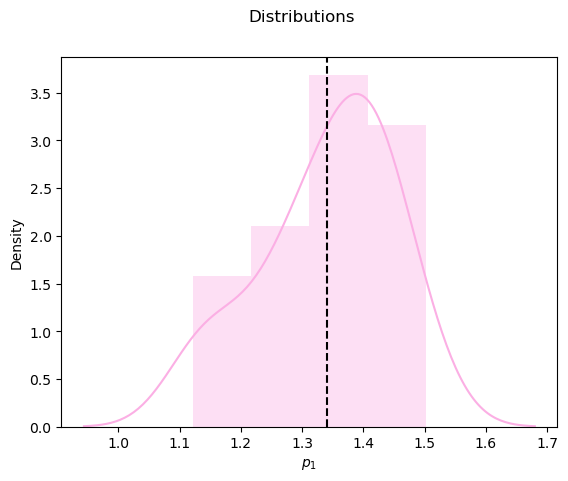

In [3]:
## Generate parameter ensemble

restrict = True
nens=20
select = 0
mean = g_xb[select] 
variance = g_B_mat[select,select]
bounds = g_val_bnds[select]

ensemble=[]
i=0
while len(ensemble) < nens:
    Xbi = np.random.normal(mean, variance)
    parameters = g_paramtrue.copy()
    parameters[select] = Xbi
    if test_bnds(parameters, bounds, restrict, select) is True:
        ensemble.append(Xbi)

params_set = np.zeros((4, nens))
for i in range(0,nens):
    params_set[:,i]=g_paramtrue.copy()
    params_set[select,i]=ensemble[i]
    
print(params_set)
fig = plt.figure().suptitle('Distributions')
weights = np.ones_like(ensemble) / float(len(ensemble))
sns.distplot(ensemble, kde=True, color=g_palette[6], hist_kws={'weights': weights}, label='prior')
plt.axvline(np.mean(ensemble), color='k', linestyle='--') 
plt.xlabel(g_xlabels[select])     

In [4]:
# Generate prior features for DA and calculate prior RMSE

GF = genDAfeatures_class.genDAfeatures_class(g_initstate, g_tf, g_deltat, g_forcing, params_set)
[hxbar,hX]=[GF.hxbar,GF.hX]
[hxbar_mat,hX_mat]=[GF.hxbar_mat,GF.hX_mat]

rmse_hxbar_1 = RMSE(hxbar_mat[0],g_xtrue_noise[0])
rmse_hxbar_2 = RMSE(hxbar_mat[1],g_xtrue_noise[1])

hX_mean=np.mean(hX_mat,2)
rmse_hX_1 = RMSE(hX_mean[0],g_xtrue_noise[0])
rmse_hX_2 = RMSE(hX_mean[1],g_xtrue_noise[1])
    
## Run 4DEnVar and calculate posterior RMSE

DA=fourDEnVar_engine.fourDEnVar_engine(ensemble, hX, g_y, g_R, hxbar)
xa=DA.xa
Xa=DA.Xa
anal=DA.xa_analytical
Xanal=DA.Xa_analytical
print(Xanal)

params_anal=g_paramtrue.copy()
params_anal[select]=xa
MR = modelruns_class.modelruns_class(g_initstate, g_tf, g_deltat, g_forcing, params_anal)
hanal_mat = MR.xf
rmse_anal_1 = RMSE(hanal_mat[0],g_xtrue_noise[0])
rmse_anal_2 = RMSE(hanal_mat[1],g_xtrue_noise[1])

params_set_anal = np.zeros((4, nens))
for i in range(0,nens):
    params_set_anal[:,i]=g_paramtrue.copy()
    params_set_anal[select,i]=Xanal[0][i]
GF = genDAfeatures_class.genDAfeatures_class(g_initstate, g_tf, g_deltat, g_forcing, params_set_anal)
[hxbaranal_mat,hXanal_mat]=[GF.hxbar_mat,GF.hX_mat]
hXanal_mean=np.mean(hXanal_mat,2)
rmse_hXanal_1 = RMSE(hXanal_mean[0],g_xtrue_noise[0])
rmse_hXanal_2 = RMSE(hXanal_mean[1],g_xtrue_noise[1])

# Print outputs
print(g_paramtrue)
print(xa)
print('estimated:', anal)
print('estimated/true', anal/g_paramtrue)
print('RMSE in hxbar - x1:', rmse_hxbar_1)
print('RMSE in estimated - x1:', rmse_anal_1)
print('RMSE in mean of updated ensemble - x1:', rmse_hXanal_1)
print('RMSE in hxbar - x2:', rmse_hxbar_2)
print('RMSE in estimated - x2:', rmse_anal_2)
print('RMSE in mean of updated ensemble - x2:', rmse_hXanal_2)

print('test RMSE in hX - x1:', rmse_hX_1)
print('test RMSE in hX - x2:', rmse_hX_2)

shape of X_dash_b: (1, 20)
shape of Y_dash_b: (2002, 20)
Xbdash*inv(I+Ybdash^T*Rinv*Ybdash)*Xbdash^T is symmetric and all eigenvalues are positive
[[1.01766095 1.01652252 1.01879841 1.01954499 1.01425081 1.01474465
  1.02091342 1.01854916 1.02120743 1.02032724 1.02091547 1.02001935
  0.99716089 1.02294701 1.01601323 1.01816586 1.01643315 1.00798811
  1.01526574 1.0347854 ]]


/Users/nataliedouglas/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[1.0, 1.0, 0.2, 0.1]
[1.0197006]
estimated: [1.01970059]
estimated/true [ 1.01970059  1.01970059  5.09850293 10.19700585]
RMSE in hxbar - x1: 0.5126801565312501
RMSE in estimated - x1: 0.026055323731553164
RMSE in mean of updated ensemble - x1: 0.023293937415162586
RMSE in hxbar - x2: 0.996021758546753
RMSE in estimated - x2: 0.05086834460120224
RMSE in mean of updated ensemble - x2: 0.04547699429458253
test RMSE in hX - x1: 0.5784805608145224
test RMSE in hX - x2: 1.1275564558784263


(0.0, 0.5)

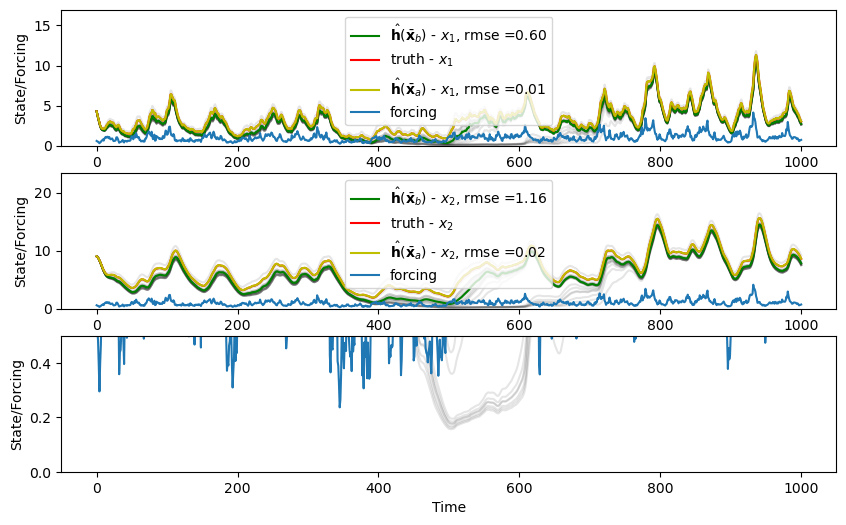

In [5]:
## Plots
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(hX_mat[0,:,:],'k', alpha=0.1)
plt.plot(g_t2,hxbar_mat[0],label=r'$\hat{\bf h}(\bar{\bf x}_b)$ - $x_1$, rmse ='+"{:.2f}".format(rmse_hxbar_1),color='g')
plt.plot(g_t2,g_xtrue_noise[0],label=r'truth - $x_1$',color='r')
plt.plot(g_t2,hanal_mat[0],label=r'$\hat{\bf h}(\bar{\bf x}_a)$ - $x_1$, rmse ='+"{:.2f}".format(rmse_anal_1),color='y')
plt.plot(g_t2,g_forcing,label='forcing')
plt.legend()
plt.ylim([0,np.max(g_xtrue_noise[0])*1.5])
plt.xlabel('Time')
plt.ylabel('State/Forcing')
plt.subplot(3,1,2)
plt.plot(hX_mat[1,:,:],'k', alpha=0.1)
plt.plot(g_t2,hxbar_mat[1],label=r'$\hat{\bf h}(\bar{\bf x}_b)$ - $x_2$, rmse ='+"{:.2f}".format(rmse_hxbar_2),color='g')
plt.plot(g_t2,g_xtrue_noise[1],label=r'truth - $x_2$',color='r')
plt.plot(g_t2,hanal_mat[1],label=r'$\hat{\bf h}(\bar{\bf x}_a)$ - $x_2$, rmse ='+"{:.2f}".format(rmse_anal_2),color='y')
plt.plot(g_t2,g_forcing,label='forcing')
plt.legend()
plt.ylim([0,np.max(g_xtrue_noise[1])*1.5])
plt.xlabel('Time')
plt.ylabel('State/Forcing')
plt.subplot(3,1,3)
plt.plot(hX_mat[1,:,:],'k', alpha=0.1)
plt.plot(g_t2,hxbar_mat[1],label=r'$\hat{\bf h}(\bar{\bf x}_b)$ - $x_2$, rmse ='+"{:.2f}".format(rmse_hxbar_2),color='g')
plt.plot(g_t2,g_xtrue_noise[1],label='truth - x2',color='r')
plt.plot(g_t2,hanal_mat[1],label=r'$\hat{\bf h}(\bar{\bf x}_a)$ - $x_2$, rmse ='+"{:.2f}".format(rmse_anal_2),color='y')
plt.plot(g_t2,g_forcing,label='forcing')
plt.xlabel('Time')
plt.ylabel('State/Forcing')
plt.ylim((0,0.5))

/Users/nataliedouglas/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nataliedouglas/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


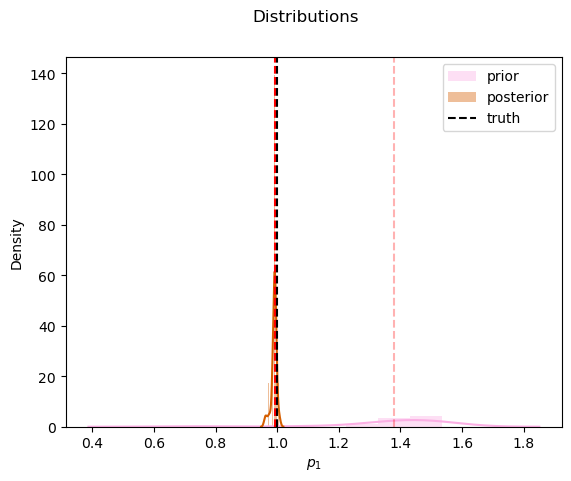

In [6]:
## Plot distributions
fig = plt.figure().suptitle('Distributions')
sns.distplot(ensemble, kde=True, color=g_palette[6], hist_kws={'weights': weights}, label='prior')
plt.axvline(np.mean(ensemble), color='r', linestyle='--',alpha=0.3) 
sns.distplot(Xa, kde=True, color=g_palette[3], hist_kws={'weights': weights}, label='posterior')
plt.axvline(xa, color='r', linestyle='--')
plt.axvline(g_paramtrue[select], color='k', linestyle='--',label='truth')
plt.xlabel(g_xlabels[select])
plt.legend()